##### Notebook 2: Model Training

Welcome to Notebook 2 of this recommendation system project!

In Notebook 1, we performed exploratory data analysis (EDA), and visualized various aspects of the data to gain insights into our anime recommendation problem.

In this notebook, we will focus on training the recommendation model. By separating the model training into a separate notebook, we ensure better memory management and organization of the project.

Let's dive in!

Note: If you haven't gone through Notebook 1 yet, I highly recommend you do so to understand the data and insights gained before moving on to the model training phase.

[Click here to access Notebook 1: Exploratory Data Analysis and Dataset Preparation](https://www.kaggle.com/code/dbdmobile/anime-recommendation-1)

In [2]:
!pip install wordcloud -q

In [3]:
### Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import warnings
warnings.filterwarnings(action='ignore')

# Data Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

# Model Training
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf

## Import necessary modules for collaborative filtering
from tensorflow.keras.layers import Input, Embedding, Dot, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from wordcloud import WordCloud
from collections import defaultdict
from collections import Counter

## Import necessary modules for content-based filtering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

In [4]:
# Load the dataset
import pandas as pd
df=pd.read_csv('../model/users-score-2023.csv', usecols=["user_id","anime_id","rating"])
print("Shape of the Dataset:",df.shape)
df.head()

Shape of the Dataset: (24325191, 3)


,user_id,anime_id,rating
0,1,21,9
1,1,48,7
2,1,320,5
3,1,49,8
4,1,304,8


In [5]:
# Checking if there are any duplicate rows
duplicated_rows = df[df.duplicated()]
print("Duplicated Rows:")
print(duplicated_rows)

Duplicated Rows:
Empty DataFrame
Columns: [user_id, anime_id, rating]
Index: []


In [6]:
# Calculating the average score
avg_score = np.mean(df['rating'])
print('Average Score:', avg_score)

Average Score: 7.622930072779285


# Data Preprocessing

In [7]:
# Scaling our "rating" column
# Create a MinMaxScaler object
scaler = MinMaxScaler(feature_range=(0, 1))

# Scale the 'score' column between 0 and 1
df['scaled_score'] = scaler.fit_transform(df[['rating']])

In [8]:
# Encoding categorical data

## Encoding user IDs
user_encoder = LabelEncoder()
df["user_encoded"] = user_encoder.fit_transform(df["user_id"])
num_users = len(user_encoder.classes_)

## Encoding anime IDs
anime_encoder = LabelEncoder()
df["anime_encoded"] = anime_encoder.fit_transform(df["anime_id"])
num_animes = len(anime_encoder.classes_)

# Printing dataset information
print("Number of unique users: {}, Number of unique anime: {}".format(num_users, num_animes))
print("Minimum rating: {}, Maximum rating: {}".format(min(df['rating']), max(df['rating'])))

Number of unique users: 270033, Number of unique anime: 16500
Minimum rating: 1, Maximum rating: 10


# Model training (collaborative filtering)

In [9]:
# Shuffle the dataset
df = shuffle(df, random_state=100)

# Create feature matrix X and target variable y
X = df[['user_encoded', 'anime_encoded']].values
y = df["scaled_score"].values

# Printing dataset information
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (24325191, 2)
Shape of y: (24325191,)


In [10]:
test_set_size = 10000  # Number of samples to include in the test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_set_size, random_state=73)

print("Number of samples in the training set:", len(y_train))
print("Number of samples in the test set:", len(y_test))

Number of samples in the training set: 24315191
Number of samples in the test set: 10000


In [11]:
# Prepare input data for model training and evaluation
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [12]:
import tensorflow as tf

# Set flag to use TPU
USE_TPU = True

try:
    if USE_TPU:
        print("🔌 Attempting to connect to TPU...")
        # Automatically detect and connect to TPU
        tpu_resolver = tf.distribute.cluster_resolver.TPUClusterResolver()  # No .connect() needed here
        tf.config.experimental_connect_to_cluster(tpu_resolver)
        tf.tpu.experimental.initialize_tpu_system(tpu_resolver)
        tpu_strategy = tf.distribute.TPUStrategy(tpu_resolver)
        print("✅ TPU initialized.")
    else:
        print("Using CPU/GPU backend.")
        # If on Colab or local with GPU, show GPU info (optional)
        # This line is specific to Jupyter or Colab
        # You can use `!nvidia-smi` only in notebooks
        # print("GPU Info:")
        # !nvidia-smi
except ValueError as e:
    print(f"❌ TPU not found or failed to connect: {e}")
    USE_TPU = False
    tpu_strategy = None

# Print TensorFlow version
print(f"🧠 TensorFlow version: {tf.__version__}")


🔌 Attempting to connect to TPU...
❌ TPU not found or failed to connect: Please provide a TPU Name to connect to.
🧠 TensorFlow version: 2.17.0


In [13]:
def RecommenderNet(num_users, num_animes, embedding_size=128):
    # User input layer and embedding layer
    user = Input(name='user_encoded', shape=[1])
    user_embedding = Embedding(name='user_embedding', input_dim=num_users, output_dim=embedding_size)(user)
    
    # Anime input layer and embedding layer
    anime = Input(name='anime_encoded', shape=[1])
    anime_embedding = Embedding(name='anime_embedding', input_dim=num_animes, output_dim=embedding_size)(anime)
    
    # Dot product of user and anime embeddings
    dot_product = Dot(name='dot_product', normalize=True, axes=2)([user_embedding, anime_embedding])
    flattened = Flatten()(dot_product)
    
    # Dense layers for prediction
    dense = Dense(64, activation='relu')(flattened)
    output = Dense(1, activation='sigmoid')(dense)
    
    # Create and compile the model
    model = Model(inputs=[user, anime], outputs=output)
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=["mae", "mse"])
    
    return model
# Checking if TPU is initialized and create the model accordingly
if USE_TPU:
    with tpu_strategy.scope():
        model = RecommenderNet(num_users, num_animes)
else:
    model = RecommenderNet(num_users, num_animes)

# Printing my model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_encoded        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_encoded       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │ 34,564,224 │ user_encoded[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  2,112,000 │ anime_encoded[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1)         │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │        128 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         65 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 36,676,417 (139.91 MB)

 Trainable params: 36,676,417 (139.91 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
## Import necessary callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping

# Define the initial learning rate, minimum learning rate, maximum learning rate, and batch size
start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005
batch_size = 10000

# Adjust the maximum learning rate and batch size if using TPU
if USE_TPU:
    max_lr = max_lr * tpu_strategy.num_replicas_in_sync
    batch_size = batch_size * tpu_strategy.num_replicas_in_sync

# Define the number of epochs for ramp-up, sustain, and exponential decay
rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

# Learning rate schedule function
def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr) / rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch - rampup_epochs - sustain_epochs) + min_lr

# Learning rate scheduler callback
lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=0)

# File path for saving the model weights
checkpoint_filepath = '/kaggle/working/myanimeweights.weights.h5'


# Model checkpoint callback to save the best weights
model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                    save_weights_only=True,
                                    monitor='val_loss',
                                    mode='min',
                                    save_best_only=True)

# Early stopping callback to prevent overfitting
early_stopping = EarlyStopping(patience=3, monitor='val_loss', mode='min', restore_best_weights=True)

# Define the list of callbacks
my_callbacks = [
    model_checkpoints,
    lr_callback,
    early_stopping
]

In [15]:
# Model training
history = model.fit(
    x=X_train_array,
    y=y_train,
    batch_size=batch_size,
    epochs=20,
    verbose=1,
    validation_data=(X_test_array, y_test),
    callbacks=my_callbacks
)

model.load_weights(checkpoint_filepath)

Epoch 1/20
2432/2432 ━━━━━━━━━━━━━━━━━━━━ 530s 217ms/step - loss: 0.6874 - mae: 0.2583 - mse: 0.0868 - val_loss: 0.6595 - val_mae: 0.2318 - val_mse: 0.0725 - learning_rate: 1.0000e-05
Epoch 2/20
2432/2432 ━━━━━━━━━━━━━━━━━━━━ 526s 216ms/step - loss: 0.6446 - mae: 0.2179 - mse: 0.0656 - val_loss: 0.6053 - val_mae: 0.1793 - val_mse: 0.0462 - learning_rate: 1.8000e-05
Epoch 3/20
2432/2432 ━━━━━━━━━━━━━━━━━━━━ 525s 216ms/step - loss: 0.5945 - mae: 0.1655 - mse: 0.0416 - val_loss: 0.5775 - val_mae: 0.1477 - val_mse: 0.0338 - learning_rate: 2.6000e-05
Epoch 4/20
2432/2432 ━━━━━━━━━━━━━━━━━━━━ 514s 211ms/step - loss: 0.5771 - mae: 0.1468 - mse: 0.0340 - val_loss: 0.5759 - val_mae: 0.1440 - val_mse: 0.0331 - learning_rate: 3.4000e-05
Epoch 5/20
2432/2432 ━━━━━━━━━━━━━━━━━━━━ 518s 213ms/step - loss: 0.5707 - mae: 0.1384 - mse: 0.0315 - val_loss: 0.5603 - val_mae: 0.1280 - val_mse: 0.0272 - learning_rate: 4.2000e-05
Epoch 6/20
2432/2432 ━━━━━━━━━━━━━━━━━━━━ 542s 222ms/step - loss: 0.5490 - mae: 

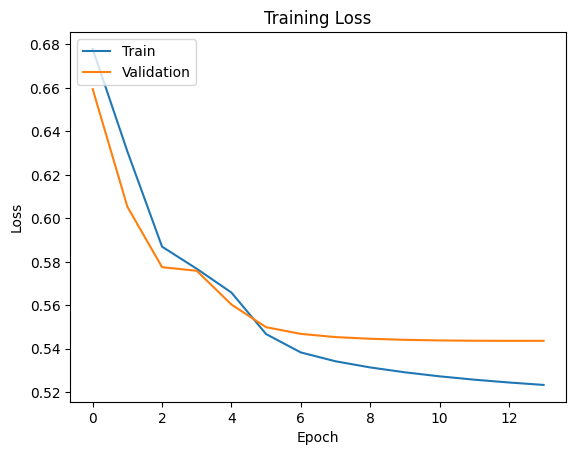

In [16]:
# Training results visualization

plt.plot(history.history["loss"][0:-2])
plt.plot(history.history["val_loss"][0:-2])
plt.title("Training Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

# Recommendation:

In [17]:
def extract_weights(name, model):
    # Get the layer by name from the model
    weight_layer = model.get_layer(name)
    
    # Get the weights from the layer
    weights = weight_layer.get_weights()[0]
    
    # Normalize the weights
    weights = weights / np.linalg.norm(weights, axis=1).reshape((-1, 1))
    
    return weights

# Extract weights for anime embeddings
anime_weights = extract_weights('anime_embedding', model)
# Extract weights for user embeddings
user_weights = extract_weights('user_embedding', model)

#### Reading the whole dataset

In [18]:
df_anime=pd.read_csv('../model/anime-dataset-2023.csv')

#### Now I want my model to recommend only those animes that have been rated by at least a certain number of users, which I will set as the threshold. This threshold helps ensure that the recommended anime titles have received a sufficient number of ratings, indicating a certain level of popularity or user engagement.

In [19]:
popularity_threshold = 50
df_anime= df_anime.query('Members >= @popularity_threshold')
print(df_anime.shape)
df_anime.head(3)      # only give rating of those movies for which atleast 200 user have rated

(22879, 24)


,anime_id,Name,English name,Other name,Score,Genres,Synopsis,Type,Episodes,Aired,...,Studios,Source,Duration,Rating,Rank,Popularity,Favorites,Scored By,Members,Image URL
0,1,Cowboy Bebop,Cowboy Bebop,カウボーイビバップ,8.75,"Action, Award Winning, Sci-Fi","Crime is timeless. By the year 2071, humanity ...",TV,26.0,"Apr 3, 1998 to Apr 24, 1999",...,Sunrise,Original,24 min per ep,R - 17+ (violence & profanity),41.0,43,78525,914193.0,1771505,https://cdn.myanimelist.net/images/anime/4/196...
1,5,Cowboy Bebop: Tengoku no Tobira,Cowboy Bebop: The Movie,カウボーイビバップ 天国の扉,8.38,"Action, Sci-Fi","Another day, another bounty—such is the life o...",Movie,1.0,"Sep 1, 2001",...,Bones,Original,1 hr 55 min,R - 17+ (violence & profanity),189.0,602,1448,206248.0,360978,https://cdn.myanimelist.net/images/anime/1439/...
2,6,Trigun,Trigun,トライガン,8.22,"Action, Adventure, Sci-Fi","Vash the Stampede is the man with a $$60,000,0...",TV,26.0,"Apr 1, 1998 to Sep 30, 1998",...,Madhouse,Manga,24 min per ep,PG-13 - Teens 13 or older,328.0,246,15035,356739.0,727252,https://cdn.myanimelist.net/images/anime/7/203...


# 1: Item Based Recommendation

In [20]:
def find_similar_animes(name, n=10, return_dist=False, neg=False):
    try:
        anime_row = df_anime[df_anime['Name'] == name].iloc[0]
        index = anime_row['anime_id']
        encoded_index = anime_encoder.transform([index])[0]
        weights = anime_weights
        dists = np.dot(weights, weights[encoded_index])
        sorted_dists = np.argsort(dists)
        n = n + 1            
        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]
        print('Animes closest to {}'.format(name))
        if return_dist:
            return dists, closest
        
        SimilarityArr = []
        
        for close in closest:
            decoded_id = anime_encoder.inverse_transform([close])[0]
            anime_frame = df_anime[df_anime['anime_id'] == decoded_id]
            
            anime_name = anime_frame['Name'].values[0]
            english_name = anime_frame['English name'].values[0]
            name = english_name if english_name != "UNKNOWN" else anime_name
            genre = anime_frame['Genres'].values[0]
            Synopsis = anime_frame['Synopsis'].values[0]
            similarity = dists[close]
            similarity = "{:.2f}%".format(similarity * 100)
            SimilarityArr.append({"Name": name, "Similarity": similarity, "Genres": genre, "Synopsis":Synopsis})
        Frame = pd.DataFrame(SimilarityArr).sort_values(by="Similarity", ascending=False)
        return Frame[Frame.Name != name]
    except:
        print('{} not found in Anime list'.format(name))

pd.set_option('display.max_colwidth', None)

In [21]:
find_similar_animes('Tensei shitara Slime Datta Ken', n=5, neg=False)  # That Time I Got Reincarnated as a Slime

Animes closest to Tensei shitara Slime Datta Ken


,Name,Similarity,Genres,Synopsis
4,The Rising of the Shield Hero,76.59%,"Action, Adventure, Drama, Fantasy","The Four Cardinal Heroes are a group of ordinary men from modern-day Japan summoned to the kingdom of Melromarc to become its saviors. Melromarc is a country plagued by the Waves of Catastrophe that have repeatedly ravaged the land and brought disaster to its citizens for centuries. The four heroes are respectively bestowed a sword, spear, bow, and shield to vanquish these Waves. Naofumi Iwatani, an otaku, becomes cursed with the fate of being the ""Shield Hero."" Armed with only a measly shield, Naofumi is belittled and ridiculed by his fellow heroes and the kingdom's people due to his weak offensive capabilities and lackluster personality.\n\nWhen the heroes are provided with resources and comrades to train with, Naofumi sets out with the only person willing to train alongside him, Malty Melromarc. He is soon betrayed by her, however, and becomes falsely accused of taking advantage of her. Naofumi then becomes heavily discriminated against and hated by the people of Melromarc for something he didn't do. With a raging storm of hurt and mistrust in his heart, Naofumi begins his journey of strengthening himself and his reputation. Further along however, the difficulty of being on his own sets in, so Naofumi buys a demi-human slave on the verge of death named Raphtalia to accompany him on his travels.\n\nAs the Waves approach the kingdom, Naofumi and Raphtalia must fight for the survival of the kingdom and protect the people of Melromarc from their ill-fated future."
3,That Time I Got Reincarnated as a Slime Season 2,76.07%,"Action, Adventure, Comedy, Fantasy","Taking a break from his time as a teacher, the powerful slime Rimuru Tempest returns to his kingdom, eponymously named Tempest, just in time to begin negotiations with a nearby nation—the Kingdom of Eurazania. While the negotiations are anything but peaceful, they do end successfully, allowing Rimuru to return and finish teaching. When trying to again return to Tempest, this time permanently, Rimuru is stopped by a mysterious figure who is somehow able to constrain the many magical abilities he has at his disposal. \n\nIn Tempest, the situation is even worse. A group of unknown humans has invaded the land and are assaulting its citizens, both influential and innocent. They are not just trying to bring harm either—they have the intent to kill. Can Rimuru overcome his powerful and dangerous foe and return to Tempest before it is too late?"
2,Dr. Stone,74.11%,"Adventure, Comedy, Sci-Fi","After five years of harboring unspoken feelings, high-schooler Taiju Ooki is finally ready to confess his love to Yuzuriha Ogawa. Just when Taiju begins his confession however, a blinding green light strikes the Earth and petrifies mankind around the world—turning every single human into stone.\n\nSeveral millennia later, Taiju awakens to find the modern world completely nonexistent, as nature has flourished in the years humanity stood still. Among a stone world of statues, Taiju encounters one other living human: his science-loving friend Senkuu, who has been active for a few months. Taiju learns that Senkuu has developed a grand scheme—to launch the complete revival of civilization with science. Taiju's brawn and Senkuu's brains combine to forge a formidable partnership, and they soon uncover a method to revive those petrified.\n\nHowever, Senkuu's master plan is threatened when his ideologies are challenged by those who awaken. All the while, the reason for mankind's petrification remains unknown."
1,That Time I Got Reincarnated as a Slime Season 2 Part 2,73.67%,"Action, Adventure, Comedy, Fantasy","The nation of Tempest is in a festive mood after successfully overcoming the surprise attack from the Falmuth Army and the Western Holy Church. Beyond the festivities lies a meeting between Tempest and its allies to decide the future of the Nation of Monsters. The aftermath of the Falmu

In [22]:
find_similar_animes('Shigatsu wa Kimi no Uso', n=5, neg=False) # Your Lie in April

Animes closest to Shigatsu wa Kimi no Uso


,Name,Similarity,Genres,Synopsis
4,ERASED,87.50%,"Mystery, Supernatural, Suspense","When tragedy is about to strike, Satoru Fujinuma finds himself sent back several minutes before the accident occurs. The detached, 29-year-old manga artist has taken advantage of this powerful yet mysterious phenomenon, which he calls ""Revival,"" to save many lives.\n \nHowever, when he is wrongfully accused of murdering someone close to him, Satoru is sent back to the past once again, but this time to 1988, 18 years in the past. Soon, he realizes that the murder may be connected to the abduction and killing of one of his classmates, the solitary and mysterious Kayo Hinazuki, that took place when he was a child. This is his chance to make things right.\n \nBoku dake ga Inai Machi follows Satoru in his mission to uncover what truly transpired 18 years ago and prevent the death of his classmate while protecting those he cares about in the present."
3,Your Name.,87.15%,"Award Winning, Drama, Supernatural","Mitsuha Miyamizu, a high school girl, yearns to live the life of a boy in the bustling city of Tokyo—a dream that stands in stark contrast to her present life in the countryside. Meanwhile in the city, Taki Tachibana lives a busy life as a high school student while juggling his part-time job and hopes for a future in architecture.\n\nOne day, Mitsuha awakens in a room that is not her own and suddenly finds herself living the dream life in Tokyo—but in Taki's body! Elsewhere, Taki finds himself living Mitsuha's life in the humble countryside. In pursuit of an answer to this strange phenomenon, they begin to search for one another.\n\nKimi no Na wa. revolves around Mitsuha and Taki's actions, which begin to have a dramatic impact on each other's lives, weaving them into a fabric held together by fate and circumstance."
2,A Silent Voice,85.76%,"Award Winning, Drama","As a wild youth, elementary school student Shouya Ishida sought to beat boredom in the cruelest ways. When the deaf Shouko Nishimiya transfers into his class, Shouya and the rest of his class thoughtlessly bully her for fun. However, when her mother notifies the school, he is singled out and blamed for everything done to her. With Shouko transferring out of the school, Shouya is left at the mercy of his classmates. He is heartlessly ostracized all throughout elementary and middle school, while teachers turn a blind eye.\n\nNow in his third year of high school, Shouya is still plagued by his wrongdoings as a young boy. Sincerely regretting his past actions, he sets out on a journey of redemption: to meet Shouko once more and make amends.\n\nKoe no Katachi tells the heartwarming tale of Shouya's reunion with Shouko and his honest attempts to redeem himself, all while being continually haunted by the shadows of his past."
1,Anohana: The Flower We Saw That Day,84.42%,"Drama, Supernatural","Jinta Yadomi is peacefully living as a recluse, spending his days away from school and playing video games at home instead. One hot summer day, his childhood friend, Meiko ""Menma"" Honma, appears and pesters him to grant a forgotten wish. He pays her no mind, which annoys her, but he doesn't really care. After all, Menma already died years ago.\n\nAt first, Jinta thinks that he is merely hallucinating due to the summer heat, but he is later on convinced that what he sees truly is the ghost of Menma. Jinta and his group of childhood friends grew apart after her untimely death, but they are drawn together once more as they try to lay Menma's spirit to rest. Re-living their pain and guilt, will they be able to find the strength to help not only Menma move on—but themselves as well?"
0,Steins;Gate,83.62%,"Drama, Sci-Fi, Suspense","Eccentric scientist Rintarou Okabe has a never-ending thirst for scientific exploration. Together with his ditzy but well-meaning friend Mayuri Shiina and his roommate Itaru Hashida, Rintarou founds the Future Gadget Laboratory in the hopes of creating technological innovations t

In [23]:
find_similar_animes('One Punch Man', n=5, neg=False)

Animes closest to One Punch Man


,Name,Similarity,Genres,Synopsis
4,Your Name.,87.65%,"Award Winning, Drama, Supernatural","Mitsuha Miyamizu, a high school girl, yearns to live the life of a boy in the bustling city of Tokyo—a dream that stands in stark contrast to her present life in the countryside. Meanwhile in the city, Taki Tachibana lives a busy life as a high school student while juggling his part-time job and hopes for a future in architecture.\n\nOne day, Mitsuha awakens in a room that is not her own and suddenly finds herself living the dream life in Tokyo—but in Taki's body! Elsewhere, Taki finds himself living Mitsuha's life in the humble countryside. In pursuit of an answer to this strange phenomenon, they begin to search for one another.\n\nKimi no Na wa. revolves around Mitsuha and Taki's actions, which begin to have a dramatic impact on each other's lives, weaving them into a fabric held together by fate and circumstance."
3,Haikyu!! 3rd Season,87.30%,Sports,"After the victory against Aoba Jousai High, Karasuno High School, once called “a fallen powerhouse, a crow that can’t fly,” has finally reached the climax of the heated Spring tournament. Now, to advance to nationals, the Karasuno team has to defeat the powerhouse Shiratorizawa Academy. Karasuno’s greatest hurdle is their adversary’s ace, Wakatoshi Ushijima, the number one player in the Miyagi Prefecture, and one of the country’s top three aces.\n\nOnly the strongest team will make it to the national tournament. Since this match is the third-year players’ last chance to qualify for nationals, Karasuno has to use everything they learned during the training camp and prior matches to attain victory. Filled with restlessness and excitement, both teams are determined to come out on top in the third season of Haikyuu!!."
2,Hunter x Hunter,87.00%,"Action, Adventure, Fantasy","Hunters devote themselves to accomplishing hazardous tasks, all from traversing the world's uncharted territories to locating rare items and monsters. Before becoming a Hunter, one must pass the Hunter Examination—a high-risk selection process in which most applicants end up handicapped or worse, deceased.\n\nAmbitious participants who challenge the notorious exam carry their own reason. What drives 12-year-old Gon Freecss is finding Ging, his father and a Hunter himself. Believing that he will meet his father by becoming a Hunter, Gon takes the first step to walk the same path.\n\nDuring the Hunter Examination, Gon befriends the medical student Leorio Paladiknight, the vindictive Kurapika, and ex-assassin Killua Zoldyck. While their motives vastly differ from each other, they band together for a common goal and begin to venture into a perilous world."
1,Fullmetal Alchemist: Brotherhood,86.74%,"Action, Adventure, Drama, Fantasy","After a horrific alchemy experiment goes wrong in the Elric household, brothers Edward and Alphonse are left in a catastrophic new reality. Ignoring the alchemical principle banning human transmutation, the boys attempted to bring their recently deceased mother back to life. Instead, they suffered brutal personal loss: Alphonse's body disintegrated while Edward lost a leg and then sacrificed an arm to keep Alphonse's soul in the physical realm by binding it to a hulking suit of armor.\n\nThe brothers are rescued by their neighbor Pinako Rockbell and her granddaughter Winry. Known as a bio-mechanical engineering prodigy, Winry creates prosthetic limbs for Edward by utilizing ""automail,"" a tough, versatile metal used in robots and combat armor. After years of training, the Elric brothers set off on a quest to restore their bodies by locating the Philosopher's Stone—a powerful gem that allows an alchemist to defy the traditional laws of Equivalent Exchange.\n\nAs Edward becomes an infamous alchemist and gains the nickname ""Fullmetal,"" the boys' journey embroils them in a growing conspiracy that threatens the fate of the world."
0,Made in Abyss,86.29%,"Adventure, Drama, Fantasy, Mystery, Sci-Fi","T

In [24]:
find_similar_animes('Mushoku Tensei: Isekai Ittara Honki Dasu', n=5, neg=False)

Animes closest to Mushoku Tensei: Isekai Ittara Honki Dasu


,Name,Similarity,Genres,Synopsis
4,Mushoku Tensei: Jobless Reincarnation Part 2,85.52%,"Drama, Fantasy, Ecchi","After the mysterious mana calamity, Rudeus Greyrat and his fierce student Eris Boreas Greyrat are teleported to the Demon Continent. There, they team up with their newfound companion Ruijerd Supardia—the former leader of the Superd's Warrior group—to form ""Dead End,"" a successful adventurer party. Making a name for themselves, the trio journeys across the continent to make their way back home to Fittoa.\n\nFollowing the advice he received from the faceless god Hitogami, Rudeus saves Kishirika Kishirisu, the Great Emperor of the Demon World, who rewards him by granting him a strange power. Now, as Rudeus masters the powerful ability that offers a number of new opportunities, it might prove to be more than what he bargained for when unexpected dangers threaten to hinder their travels."
3,Demon Slayer: Kimetsu no Yaiba,70.81%,"Action, Award Winning, Fantasy","Ever since the death of his father, the burden of supporting the family has fallen upon Tanjirou Kamado's shoulders. Though living impoverished on a remote mountain, the Kamado family are able to enjoy a relatively peaceful and happy life. One day, Tanjirou decides to go down to the local village to make a little money selling charcoal. On his way back, night falls, forcing Tanjirou to take shelter in the house of a strange man, who warns him of the existence of flesh-eating demons that lurk in the woods at night.\n\nWhen he finally arrives back home the next day, he is met with a horrifying sight—his whole family has been slaughtered. Worse still, the sole survivor is his sister Nezuko, who has been turned into a bloodthirsty demon. Consumed by rage and hatred, Tanjirou swears to avenge his family and stay by his only remaining sibling. Alongside the mysterious group calling themselves the Demon Slayer Corps, Tanjirou will do whatever it takes to slay the demons and protect the remnants of his beloved sister's humanity."
2,Demon Slayer: Kimetsu no Yaiba - The Movie: Mugen Train,68.76%,"Action, Fantasy","After a string of mysterious disappearances begin to plague a train, the Demon Slayer Corps' multiple attempts to remedy the problem prove fruitless. To prevent further casualties, the Flame Pillar, Kyoujurou Rengoku, takes it upon himself to eliminate the threat. Accompanying him are some of the Corps' most promising new blood: Tanjirou Kamado, Zenitsu Agatsuma, and Inosuke Hashibira, who all hope to witness the fiery feats of this model demon slayer firsthand.\n\nUnbeknownst to them, the demonic forces responsible for the disappearances have already put their sinister plan in motion. Under this demonic presence, the group must muster every ounce of their willpower and draw their swords to save all two hundred passengers onboard. Kimetsu no Yaiba Movie: Mugen Ressha-hen delves into the deepest corners of Tanjirou's mind, putting his resolve and commitment to duty to the test."
1,Demon Slayer: Kimetsu no Yaiba Entertainment District Arc,68.16%,"Action, Fantasy","The devastation of the Mugen Train incident still weighs heavily on the members of the Demon Slayer Corps. Despite being given time to recover, life must go on, as the wicked never sleep: a vicious demon is terrorizing the alluring women of the Yoshiwara Entertainment District. The Sound Pillar, Tengen Uzui, and his three wives are on the case. However, when he soon loses contact with his spouses, Tengen fears the worst and enlists the help of Tanjirou Kamado, Zenitsu Agatsuma, and Inosuke Hashibira to infiltrate the district's most prominent houses and locate the depraved Upper Rank demon."
0,That Time I Got Reincarnated as a Slime Season 2,67.94%,"Action, Adventure, Comedy, Fantasy","Taking a break from his time as a teacher, the powerful slime Rimuru Tempest returns to his kingdom, eponymously named Tempest, just in time to begin negotiations with a nearby nation—the Kingdom of Eurazania. While the neg

# 2: User Based Recommendation
#### (The user-based recommendation system is divided into three parts:)

## Part 1: Finding Similar Users
#### In this part, we randomly select a user from the dataset and find similar users based on their anime preferences. The find_similar_users function calculates the similarity between users using a weighted matrix and returns a dataframe of similar users. The function takes an input user, number of similar users to find (n), and other optional parameters. The result is a list of similar users to the input user.

In [25]:
def find_similar_users(item_input, n=10, return_dist=False, neg=False):
    try:
        index = item_input
        encoded_index = user_encoder.transform([index])[0]
        weights = user_weights
        dists = np.dot(weights, weights[encoded_index])
        sorted_dists = np.argsort(dists)
        n = n + 1
        
        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]
            
        SimilarityArr = []
        
        for close in closest:
            similarity = dists[close]
            if isinstance(item_input, int):
                decoded_id = user_encoder.inverse_transform([close])[0]
                SimilarityArr.append({"similar_users": decoded_id, "similarity": similarity})
        Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False)
        return Frame
    except:
        print('\033[1m{}\033[0m, Not Found in User list'.format(item_input))

In [26]:
# Select a random user
ratings_per_user = df.groupby('user_id').size()
random_user = int(ratings_per_user[ratings_per_user < 500].sample(1, random_state=None).index[0])

# Find similar users to the random user
similar_users = find_similar_users(random_user, n=10, neg=False)
similar_users = similar_users[similar_users.similarity > 0.4]
similar_users = similar_users[similar_users.similar_users != random_user]
similar_users

,similar_users,similarity
9,1130717,0.453250
8,1231531,0.434793
7,295076,0.430152
6,470395,0.429082
5,59575,0.428752
4,45217,0.422586
3,19774,0.420466
2,42841,0.416204
1,373095,0.410574
0,78877,0.408759


## Part 2: User Preferences
#### This part focuses on understanding the preferences of the selected user. The get_user_preferences function takes a user ID as input and retrieves the anime preferences of that user. It considers the top-rated animes by the user and analyzes the genres they prefer. The function also provides an option to plot a word cloud to visualize the preferred genres. The output is a dataframe containing the anime titles and their associated genres.

In [27]:
# Function to display a word cloud of preferred genres
def showWordCloud(all_genres):
    genres_cloud = WordCloud(width=700, height=400, background_color='white', colormap='gnuplot').generate_from_frequencies(all_genres)
    plt.figure(figsize=(10, 8))
    plt.imshow(genres_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

def get_user_preferences(user_id, plot=False, verbose=0):
    animes_watched_by_user = df[df['user_id'] == user_id]
    
    if animes_watched_by_user.empty:
        print("User #{} has not watched any animes.".format(user_id))
        return pd.DataFrame()
    
    user_rating_percentile = np.percentile(animes_watched_by_user.rating, 75)
    animes_watched_by_user = animes_watched_by_user[animes_watched_by_user.rating >= user_rating_percentile]
    top_animes_user = (
        animes_watched_by_user.sort_values(by="rating", ascending=False)
        .anime_id.values
    )
    
    anime_df_rows = df_anime[df_anime["anime_id"].isin(top_animes_user)]
    anime_df_rows = anime_df_rows[["Name", "Genres"]]
    
    if verbose != 0:
        print("User \033[1m{}\033[0m has watched {} anime(s) with an average rating of {:.1f}/10\n".format(
            user_id, len(animes_watched_by_user), animes_watched_by_user['rating'].mean()
        ))
        print('\033[1m----- Preferred genres----- \033[0m\n')

    if plot:
        genres_list = []
        for genres in anime_df_rows['Genres']:
            if isinstance(genres, str):
                for genre in genres.split(','):
                    genres_list.append(genre.strip())

        showWordCloud(dict(Counter(genres_list)))
    
    return anime_df_rows

User 1250753 has watched 3 anime(s) with an average rating of 10.0/10

----- Preferred genres----- 



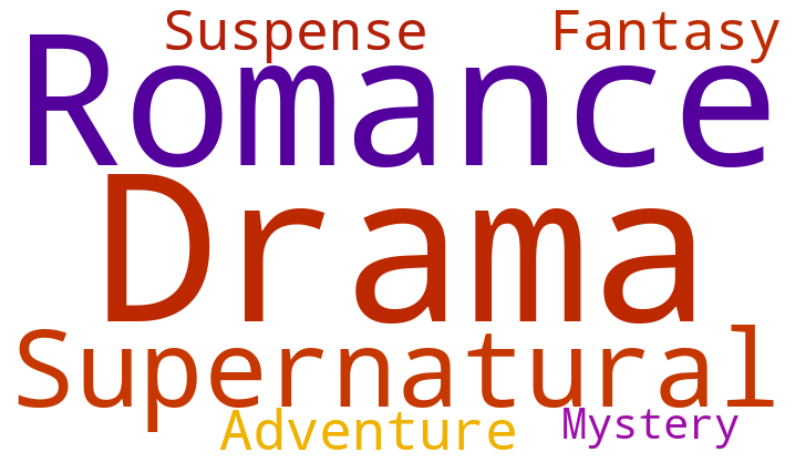

,Name,Genres
298,Paradise Kiss,"Drama, Romance"
1393,Death Note,"Supernatural, Suspense"
4161,Pandora Hearts,"Adventure, Fantasy, Mystery"


In [28]:
# Get user preferences for the random user
user_pref = get_user_preferences(random_user, plot=True, verbose=1)
pd.DataFrame(user_pref).head(5)

## Part 3: Recommending Animes for a User
#### In the final part, we recommend animes to the selected user based on the preferences of similar users. The get_recommended_animes function iterates through the list of similar users, retrieves their preferences, and identifies animes that are not present in the preferences of the selected user. It then generates a list of recommended animes along with their genres and a brief synopsis. The output is a dataframe containing the recommended animes for the user.

In [29]:
def get_recommended_animes(similar_users, user_pref, n=10):
    recommended_animes = []
    anime_list = []
    
    for user_id in similar_users.similar_users.values:
        pref_list = get_user_preferences(int(user_id))
        if not pref_list.empty:  # Check if user has watched any animes
            pref_list = pref_list[~pref_list["Name"].isin(user_pref["Name"].values)]
            anime_list.append(pref_list.Name.values)
            
    if len(anime_list) == 0:
        print("No anime recommendations available for the given users.")
        return pd.DataFrame()
    
    anime_list = pd.DataFrame(anime_list)
    sorted_list = pd.DataFrame(pd.Series(anime_list.values.ravel()).value_counts()).head(n)
    # Count the occurrences of each anime in the entire dataset
    anime_count = df['anime_id'].value_counts()
    
    for i, anime_name in enumerate(sorted_list.index):
        if isinstance(anime_name, str):
            try:
                anime_id = df_anime[df_anime.Name == anime_name].anime_id.values[0]
                english_name = df_anime[df_anime['Name'] == anime_name]['English name'].values[0]
                name = english_name if english_name != "UNKNOWN" else anime_name
                genre = df_anime[df_anime.Name == anime_name].Genres.values[0]
                Synopsis = df_anime[df_anime.Name == anime_name].Synopsis.values[0]
                n_user_pref = anime_count.get(anime_id, 0)  # Get the total count of users who have watched this anime
                recommended_animes.append({
                    "n": n_user_pref,
                    "anime_name": anime_name, 
                    "Genres": genre, 
                    "Synopsis": Synopsis
                })
            except:
                pass
    return pd.DataFrame(recommended_animes)

In [30]:
# Get recommended animes for the random user
recommended_animes = get_recommended_animes(similar_users, user_pref, n=10)

print('\n> Top recommendations for user: {}'.format(random_user))
recommended_animes


> Top recommendations for user: 1250753


,n,anime_name,Genres,Synopsis
0,90132,Bleach,"Action, Adventure, Fantasy","Ichigo Kurosaki is an ordinary high schooler—until his family is attacked by a Hollow, a corrupt spirit that seeks to devour human souls. It is then that he meets a Soul Reaper named Rukia Kuchiki, who gets injured while protecting Ichigo's family from the assailant. To save his family, Ichigo accepts Rukia's offer of taking her powers and becomes a Soul Reaper as a result.\n\nHowever, as Rukia is unable to regain her powers, Ichigo is given the daunting task of hunting down the Hollows that plague their town. However, he is not alone in his fight, as he is later joined by his friends—classmates Orihime Inoue, Yasutora Sado, and Uryuu Ishida—who each have their own unique abilities. As Ichigo and his comrades get used to their new duties and support each other on and off the battlefield, the young Soul Reaper soon learns that the Hollows are not the only real threat to the human world."
1,33204,Rurouni Kenshin: Meiji Kenkaku Romantan,"Action, Adventure, Comedy, Romance","In the final years of the Bakumatsu era lived a legendary assassin known as Hitokiri Battousai. Feared as a merciless killer, he was unmatched throughout the country, but mysteriously disappeared at the peak of the Japanese Revolution. It has been ten peaceful years since then, but the very mention of Battousai still strikes terror into the hearts of war veterans.\n\nUnbeknownst to them, Battousai has abandoned his bloodstained lifestyle in an effort to repent for his sins, now living as Kenshin Himura, a wandering swordsman with a cheerful attitude and a strong will. Vowing never to kill again, Kenshin dedicates himself to protecting the weak. One day, he stumbles across Kaoru Kamiya at her kendo dojo, which is being threatened by an impostor claiming to be Battousai. After receiving help from Kenshin, Kaoru allows him to stay at the dojo, and so the former assassin temporarily ceases his travels.\n\nRurouni Kenshin: Meiji Kenkaku Romantan tells the story of Kenshin as he strives to save those in need of saving. However, as enemies from both past and present begin to emerge, will the reformed killer be able to uphold his new ideals?"
2,45719,Shingeki no Kyojin,"Action, Award Winning, Drama, Suspense","Centuries ago, mankind was slaughtered to near extinction by monstrous humanoid creatures called Titans, forcing humans to hide in fear behind enormous concentric walls. What makes these giants truly terrifying is that their taste for human flesh is not born out of hunger but what appears to be out of pleasure. To ensure their survival, the remnants of humanity began living within defensive barriers, resulting in one hundred years without a single titan encounter. However, that fragile calm is soon shattered when a colossal Titan manages to breach the supposedly impregnable outer wall, reigniting the fight for survival against the man-eating abominations.\n\nAfter witnessing a horrific personal loss at the hands of the invading creatures, Eren Yeager dedicates his life to their eradication by enlisting into the Survey Corps, an elite military unit that combats the merciless humanoids outside the protection of the walls. Eren, his adopted sister Mikasa Ackerman, and his childhood friend Armin Arlert join the brutal war against the Titans and race to discover a way of defeating them before the last walls are breached."
3,89579,Naruto,"Action, Adventure, Fantasy","Moments prior to Naruto Uzumaki's birth, a huge demon known as the Kyuubi, the Nine-Tailed Fox, attacked Konohagakure, the Hidden Leaf Village, and wreaked havoc. In order to put an end to the Kyuubi's rampage, the leader of the village, the Fourth Hokage, sacrificed his life and sealed the monstrous beast inside the newborn Naruto.\n\nNow, Naruto is a hyperactive and knuckle-headed ninja still living in Konohagakure. Shunned because of the Kyuubi inside him, Naruto struggles to find his place in the village, while his burning desi

# Model training (content-based filtering)

In [31]:
# Create a TF-IDF vectorizer
tfidf = TfidfVectorizer(stop_words='english')

# Define a generator to compute TF-IDF matrix on the fly
tfidf_matrix_generator = tfidf.fit_transform((genre for genre in df_anime['Genres'].values.astype('U')))

# Compute cosine similarity matrix as a sparse matrix
cosine_sim_sparse = linear_kernel(tfidf_matrix_generator, tfidf_matrix_generator)

# 2: Content-Based Recommendation

In [32]:
# Function to get recommendations based on cosine similarity, genre, and ratings based on score
def get_recommendations(title, cosine_sim, df):
    idx = df_anime[df_anime['Name'] == title].index[0]

    # Compute the similarity scores between the anime at the given index and all other animes
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Filter out animes with unknown scores
    valid_scores = [x for x in sim_scores if df_anime.iloc[x[0]]['Score'] != "UNKNOWN"]

    # Sort the valid anime similarity scores based on the cosine similarity and ratings score in descending order
    sorted_scores = sorted(valid_scores, key=lambda x: (x[1], df_anime.iloc[x[0]]['Score']), reverse=True)

    # Get the top 10 similar animes (excluding the anime itself)
    top_animes = [x for x in sorted_scores if x[0] != idx][:10]

    # Extract the indices of the recommended animes
    recommended_indices = [idx for idx, _ in top_animes]
    recommended_animes = df_anime.iloc[recommended_indices][['Name', 'Genres', 'Score']]
    return recommended_animes

In [33]:
# Example usage: Get recommendations for an anime
anime_title = 'Kono Subarashii Sekai ni Shukufuku wo!'
recommendations = get_recommendations(anime_title, cosine_sim_sparse, df_anime)
print(f'Recommendations for "{anime_title}":')
recommendations

Recommendations for "Kono Subarashii Sekai ni Shukufuku wo!":


,Name,Genres,Score
14578,Kono Subarashii Sekai ni Shukufuku wo! Movie: Kurenai Densetsu,"Adventure, Comedy, Fantasy",8.45
11572,Kono Subarashii Sekai ni Shukufuku wo! 2,"Adventure, Comedy, Fantasy",8.27
6241,Doraemon Movie 31: Shin Nobita to Tetsujin Heidan - Habatake Tenshi-tachi,"Adventure, Comedy, Fantasy",8.14
12451,Kono Subarashii Sekai ni Shukufuku wo! 2: Kono Subarashii Geijutsu ni Shukufuku wo!,"Adventure, Comedy, Fantasy",8.03
502,Slayers Next,"Adventure, Comedy, Fantasy",8.02
1068,Slayers Try,"Adventure, Comedy, Fantasy",7.81
11859,Little Witch Academia (TV),"Adventure, Comedy, Fantasy",7.81
12531,Mahoujin Guruguru (2017),"Adventure, Comedy, Fantasy",7.81
7105,Little Witch Academia,"Adventure, Comedy, Fantasy",7.8
8061,Little Witch Academia: Mahoujikake no Parade,"Adventure, Comedy, Fantasy",7.75


In [34]:
anime_title = 'One Piece'
recommendations = get_recommendations(anime_title, cosine_sim_sparse, df_anime)
print(f'Recommendations for "{anime_title}":')
recommendations

Recommendations for "One Piece":


,Name,Genres,Score
16617,Bleach: Sennen Kessen-hen,"Action, Adventure, Fantasy",9.07
6456,Hunter x Hunter (2011),"Action, Adventure, Fantasy",9.04
115,Hunter x Hunter,"Action, Adventure, Fantasy",8.41
116,Hunter x Hunter: Original Video Animation,"Action, Adventure, Fantasy",8.31
1574,Naruto: Shippuuden,"Action, Adventure, Fantasy",8.26
19600,Jigokuraku,"Action, Adventure, Fantasy",8.26
118,Hunter x Hunter: Greed Island Final,"Action, Adventure, Fantasy",8.25
23239,Dungeon ni Deai wo Motomeru no wa Machigatteiru Darou ka IV: Fuka Shou - Yakusai-hen,"Action, Adventure, Fantasy",8.24
7799,Magi: The Kingdom of Magic,"Action, Adventure, Fantasy",8.22
14699,One Piece Movie 14: Stampede,"Action, Adventure, Fantasy",8.22
